# $\Delta$ z Value
Obtains a topographic profile for each road comparing its minimum to minima obtained from offset profile lines. This comparison is reported as the delta value.

Assumes transportation routes, from the National Transportation Dataset, align well with elevation data, from the Best Available Topographic dataset.

### Author
John Wall (jwall@Dewberry.com)

### Import libraries

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely import geometry, ops
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
from rasterstats import zonal_stats, point_query

### Load data

In [2]:
streams = "/mnt/c/gis/fcast_data/sample_streams_broad.shp"
roads = "/mnt/c/gis/fcast_data/sample_roads_broad.shp"
dem = "/mnt/c/gis/fcast_data/tiffs/c67567_aoi.tif"

### Code

In [3]:
# Set variables based on GIS
buffer_dist = 50
offset_dist = 45
prj = {'proj': 'aea', 'lat_1': 20, 'lat_2': 60, 'lat_0': 40,
             'lon_0': -96, 'x_0': 0, 'y_0': 0, 'ellps': 'GRS80',
             'units': 'm', 'no_defs': True}

In [4]:
# Ensure everything is projected properly
our_prj = prj
roads_prj = gpd.read_file(roads).to_crs(our_prj)
stream_prj = gpd.read_file(streams).to_crs(our_prj)

In [5]:
# Group roads together
roads_diss = roads_prj.dissolve(by='FULL_STREE')

In [15]:
# Define some functions
def gdf_intersection(evaluator:gpd.geodataframe.GeoDataFrame,
                     evaluatee:gpd.geodataframe.GeoDataFrame) -> gpd.geodataframe.GeoDataFrame:
    """Finds intersections between two geodataframes returning a list of intersection geometries.
       When lines are passed, points are returned. When polygons and lines are passed, lines are
       returned.
    """
    intersection_dict = {}
    for evaluator_shape in evaluator.geometry:
        for i, evaluatee_shape in enumerate(evaluatee.geometry):
            evaluation = evaluator_shape.intersection(evaluatee_shape)
            # If intersection is not blank
            if type(evaluation) is not shapely.geometry.collection.GeometryCollection:
                # Append the point to the list
                intersection_dict[evaluatee.index[i]] = evaluation
    gdf = gpd.GeoDataFrame(intersection_dict.items(), columns=['name','geometry'])
    gdf_out = gdf.explode().droplevel(0).reset_index(0, drop=True)
    
    return gdf_out
    

def shape_explode(shapes:list) -> list:
    """Ensures all shapes are singles opposed to multi"""
    singles = []
    for shape in shapes:
        type_name = type(shape).__name__
        if 'Multi' in type_name:
            if 'MultiPoint' in type_name:
                singles = singles + list(shape)
            elif 'MultiLineString' in type_name:
                singles = singles + [ops.linemerge(shape)]
            else:
                print('Unsupported data type!')
        else:
            singles = singles + [shape]
    return singles

In [16]:
# Find intersections between streams and roads
gdf_intersection = gdf_intersection(stream_prj, roads_diss)

In [34]:
# Buffer intersections by user provided distance
gdf_intersection['buffer_polygon'] = gdf_intersection.geometry.apply(lambda point: point.buffer(buffer_dist))
gdf_intersection

,name,geometry,buffer_polygon
0,Hickory Grove Rd,POINT Z (1282149.643935903 -456050.3832345863 0),POLYGON ((1282199.643935903 -456050.3832345863...
1,Sen Marshall Arthur Rauch Hwy,POINT Z (1281762.034077861 -455608.0870196882 0),POLYGON ((1281812.034077861 -455608.0870196882...
2,Sen Marshall Arthur Rauch Hwy,POINT Z (1281770.284896353 -455623.3306915585 0),POLYGON ((1281820.284896353 -455623.3306915585...


In [39]:
def inline_intersect(evaluator, field_name, evaluatee, out_field):
    # Obtain only the geometry field
    evaluator_shapes = list(evaluator[field_name])
    evaluatee_shapes = list(evaluatee.geometry)
    
    test_list = []
    for i, evaluator_shape in enumerate(evaluator_shapes):
        for evaluatee_shape in evaluatee_shapes:
            evaluation = evaluator_shape.intersection(evaluatee_shape)
            # If intersection is not blank
            if type(evaluation) is not shapely.geometry.collection.GeometryCollection:
                evaluator.iloc[i][out_field] = evaluation
#                 evaluator.loc[i][out_field] = evaluation
#                 test_list.append(evaluation)
#     return test_list
#     return evaluator_shapes

In [41]:
inline_intersect(gdf_intersection, 'buffer_polygon', roads_diss, 'clipped')
gdf_intersection

,name,geometry,buffer_polygon
0,Hickory Grove Rd,POINT Z (1282149.643935903 -456050.3832345863 0),POLYGON ((1282199.643935903 -456050.3832345863...
1,Sen Marshall Arthur Rauch Hwy,POINT Z (1281762.034077861 -455608.0870196882 0),POLYGON ((1281812.034077861 -455608.0870196882...
2,Sen Marshall Arthur Rauch Hwy,POINT Z (1281770.284896353 -455623.3306915585 0),POLYGON ((1281820.284896353 -455623.3306915585...


In [93]:
gdf_intersection

,name,geometry,buffer_polygon,road_segments,clipped
0,Hickory Grove Rd,POINT Z (1282149.643935903 -456050.3832345863 0),POLYGON ((1282199.643935903 -456050.3832345863...,(),LINESTRING (1282117.590556016 -456088.73129499...
1,Sen Marshall Arthur Rauch Hwy,POINT Z (1281762.034077861 -455608.0870196882 0),POLYGON ((1281812.034077861 -455608.0870196882...,(),(LINESTRING (1281717.469997054 -455630.6673164...
2,Sen Marshall Arthur Rauch Hwy,POINT Z (1281770.284896353 -455623.3306915585 0),POLYGON ((1281820.284896353 -455623.3306915585...,(),(LINESTRING (1281720.818252516 -455630.2040469...


In [ ]:
gdf_intersection['road_segments'] = gdf_intersection.apply(alt_intersect, axis=1)

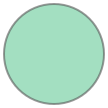

In [67]:
gs_buffs = gpd.GeoSeries(gdf_intersection.buffer_polygon)
gs_buffs[0]

In [71]:
gs_buffs[0].intersection(roads_diss.geometry[0])

In [44]:
gdf_intersection['road_segments'] = gdf_intersection.buffer_polygon.intersection(roads_diss)

AttributeError: 'Series' object has no attribute 'intersection'

In [52]:
intersect_list = []
for poly in gdf_intersection.buffer_polygon:
    road_geom = roads_diss.geometry
    intersect_list.append(poly.intersection(road_geom))

AttributeError: 'GeoSeries' object has no attribute '_geom'

In [46]:
[poly.intersection(roads_diss) for poly in gdf_intersection.buffer_polygon]

AttributeError: 'GeoDataFrame' object has no attribute '_geom'

In [36]:
# Clip roads by buffer
def clip_roads(row):
    return row['buffer_polygon'].intersection(roads_diss)

gdf_intersection['road_segments'] = gdf_intersection.apply(lambda row: row['buffer_polygon'])
# clipped_roads = intersection_buffers.intersection(intersecting_roads)

KeyError: ('buffer_polygon', 'occurred at index name')

In [30]:
intersections

,name,geometry,buffer_polygon,road_segments
0,Hickory Grove Rd,POINT Z (1282149.643935903 -456050.3832345863 0),POLYGON ((1282199.643935903 -456050.3832345863...,POLYGON ((1282209.631890465 -456049.8925578431...
1,Sen Marshall Arthur Rauch Hwy,POINT Z (1281762.034077861 -455608.0870196882 0),POLYGON ((1281812.034077861 -455608.0870196882...,POLYGON ((1281822.022032423 -455607.5963429451...
2,Sen Marshall Arthur Rauch Hwy,POINT Z (1281770.284896353 -455623.3306915585 0),POLYGON ((1281820.284896353 -455623.3306915585...,POLYGON ((1281830.272850915 -455622.8400148154...


In [ ]:
intersections = gdf_intersection(stream_prj, roads_diss)

,name,geometry
0,Hickory Grove Rd,POINT Z (1282149.643935903 -456050.3832345863 0)
1,Sen Marshall Arthur Rauch Hwy,(POINT Z (1281762.034077861 -455608.0870196882...


In [243]:
# Pull intersections into a GeoDataFrame
point_gdf = gpd.GeoDataFrame(points, columns=['geometry'])
point_gdf.crs = prj

In [ ]:
# Obtain only the geometry field
# evaluator_shapes = list(evaluator.geometry)
# evaluatee_shapes = list(evaluatee.geometry)

# Intersect streams and roads
road_list = []
intersection_list = []
for evaluator_shape in evaluator.geometry:
    for evaluatee_shape in evaluatee.geometry:
        evaluation = evaluator_shape.intersection(evaluatee_shape)
        # If intersection is not blank
        if type(evaluation) is not shapely.geometry.collection.GeometryCollection:
            # Append the point to the list
            road_list.append(evaluatee.index)
            intersection_list.append(evaluation)
return intersection_list, road_list

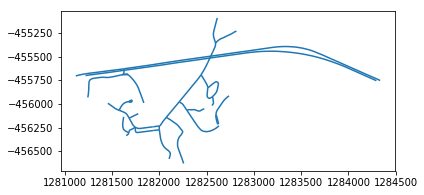

In [279]:
roads_lean.plot()

In [258]:
point_gdf.index

RangeIndex(start=0, stop=3, step=1)

In [261]:
# Drop all roads information besides index and geometry
roads_lean = roads_diss[['geometry']].copy()
roads_lean['name'] = roads_lean.index
roads_lean.reset_index(inplace=True)
roads_lean.drop(columns=['FULL_STREE'], inplace=True)

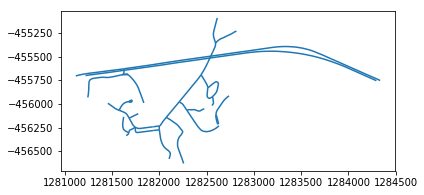

In [279]:
roads_lean.plot()

In [281]:
# Spatially join intersections and lean roads
attr_points = gpd.sjoin(point_gdf, roads_lean, how='left', op='intersects')
attr_points

,geometry,buffer,index_right,name
0,POINT Z (1282149.643935903 -456050.3832345863 0),POLYGON ((1282199.643935903 -456050.3832345863...,NaN,NaN
1,POINT Z (1281762.034077861 -455608.0870196882 0),POLYGON ((1281812.034077861 -455608.0870196882...,NaN,NaN
2,POINT Z (1281770.284896353 -455623.3306915585 0),POLYGON ((1281820.284896353 -455623.3306915585...,NaN,NaN


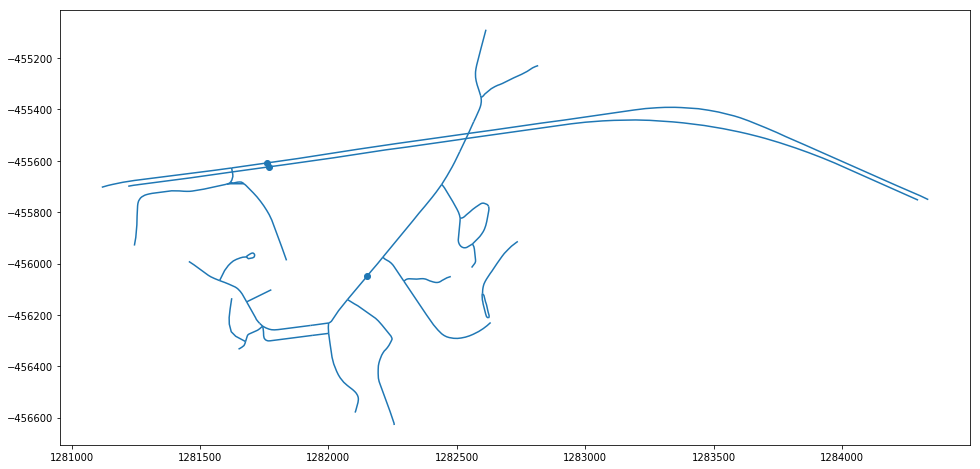

In [274]:
fig, ax = plt.subplots(figsize = (20,8))
point_gdf.plot(ax=ax);
roads_lean.plot(ax=ax);

In [159]:
# Create buffers from intersection points
intersection_buffers = [point.buffer(buffer_dist) for point in points]
gdf_buff = gpd.GeoDataFrame(intersection_buffers, columns=['geometry'])

In [177]:
# Clip roads
clipped_roads = gdf_intersection(gdf_buff, roads_diss)

In [ ]:
clipped_roads_singles = shape_explode(clipped_roads)

In [214]:
list(unary_union(clipped_roads_singles))

In [223]:
new_singles = []
for multi_line in clipped_roads_singles[1:3]:
    new_singles = new_singles + list(unary_union(multi_line))
new_singles

In [224]:
list(unary_union(new_singles))

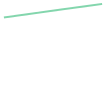

In [220]:
list(unary_union(multi_line))[0]

In [204]:
from shapely.ops import unary_union

In [205]:
list(ops.linemerge(list(unary_union(new_singles))))

In [180]:
singles = []
for shape in clipped_roads:
    type_name = type(shape).__name__
    if 'Multi' in type_name:
        if 'MultiLineString' in type_name:
            singles.append(ops.linemerge(shape))
singles

In [175]:
from shapely.ops import linemerge

In [176]:
list(linemerge(clipped_roads))

NotImplementedError: Multi-part geometries do not provide a coordinate sequence

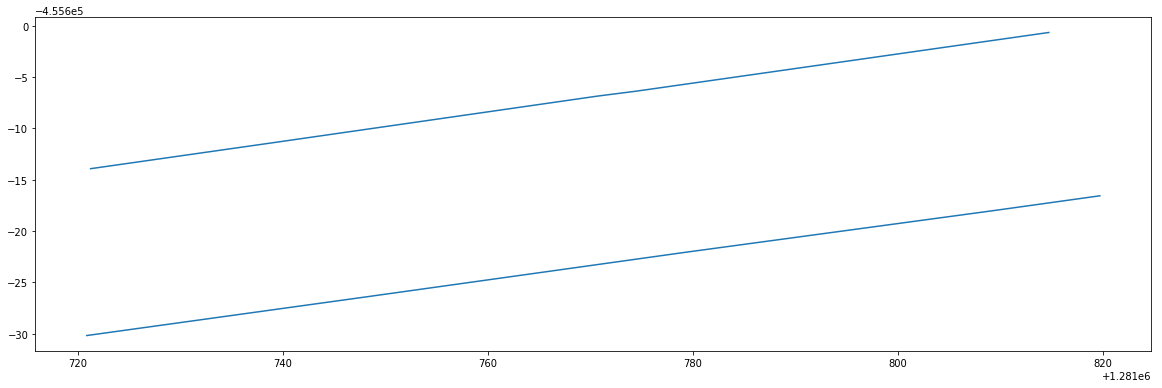

In [211]:
gdf_roads = gpd.GeoDataFrame(list(unary_union(multi_line)), columns=['geometry'])
fig, ax = plt.subplots(figsize = (20,8))
gdf_roads.plot(ax=ax);

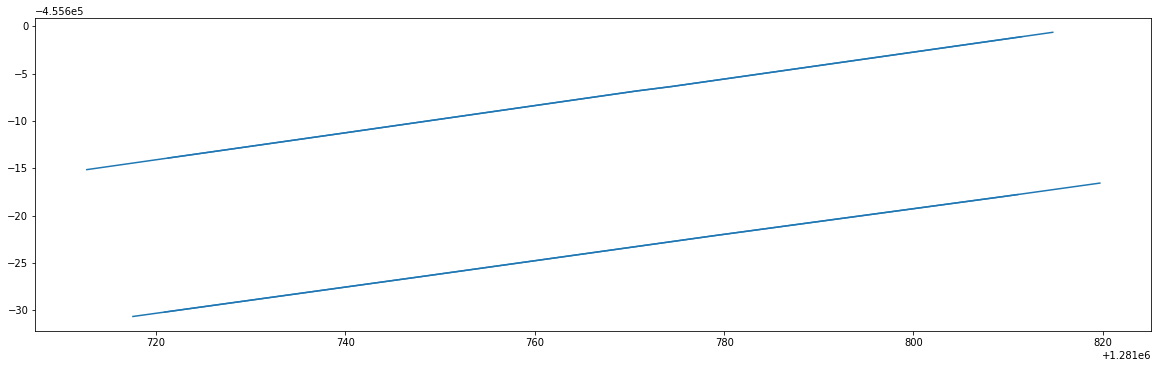

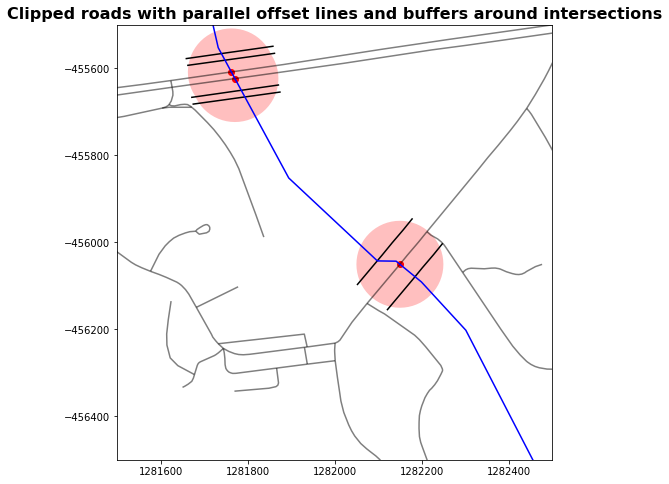

In [3]:
stream_shape = list(stream_prj.geometry)[0]
gdf_roads_diss = gdf_roads.dissolve(by='FULL_STREE')

intersecting_roads = gdf_roads_diss[gdf_roads_diss.geometry.apply(lambda row: stream_shape.intersects(row))].copy()
intersections = intersecting_roads.geometry.apply(lambda row: stream_shape.intersection(row))
intersection_buffers = intersections.buffer(buffer_dist)

clipped_roads = intersection_buffers.intersection(intersecting_roads)

single_lines = {}
for i, road in enumerate(clipped_roads):
    if type(road) is shapely.geometry.multilinestring.MultiLineString:
        single_lines[clipped_roads.index[i]] = ops.linemerge(road)
    else:
        single_lines[clipped_roads.index[i]] = road

# Resulting dictionary needs to be exploded due to roads with same
#     name. For example, if the road is an interstate.
explode_lines = gpd.GeoDataFrame(single_lines.items(), columns=['road','geometry'])
explode_lines = explode_lines.explode().droplevel(0).reset_index(0, drop=True)

# Possibly suboptimal method to create left and right offsets
df_list = []
for side in ['left', 'right']:
    explode_lines['side'] = side
    explode_lines['offset'] = explode_lines.geometry.apply(lambda road: road.parallel_offset(offset_dist, side, resolution=1))
    df_list.append(explode_lines.copy())
offset = pd.concat(df_list).reset_index(0, drop=True)

# Carry out some organization
offset['geometry'] = offset['offset']
offset.drop(columns=['offset'], inplace=True)

# Showcase the results
fig, ax = plt.subplots(figsize = (20,8))
offset.plot(color='k', ax=ax);
gdf_roads.plot(color='k', alpha=0.5, ax=ax);
stream_prj.plot(color='b', ax=ax);
intersections.plot(color='r', ax=ax);
intersection_buffers.plot(color='r', alpha=0.25, ax=ax);
ax.set_title("Clipped roads with parallel offset lines and buffers around intersections", fontsize=16, fontweight='bold');
ax.set_xlim(1281500,1282500);
ax.set_ylim(-456500, -455500);

In [154]:
type(roads_diss.geometry[1])

shapely.geometry.multilinestring.MultiLineString

In [142]:
clipped_roads_singles